In [1]:
import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

CUDA Available: True


In [2]:
import pandas as pd
df=pd.read_csv(r"C:\Users\psg\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\train.csv")
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
df = df.rename(columns={'Class Index':'label'})
df.head()

,label,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
df['text']=(df['Title']+df['Description'])
df.drop(columns=['Title','Description'],axis=1,inplace=True)
df.head()

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [5]:
import re 
def remove_punctuations(text):
     text=re.sub(r'[\\-]',' ',text)
     text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
     return text

df['text']=df['text'].apply(remove_punctuations)
df.head()

,label,text
0,3,Wall St Bears Claw Back Into the Black Reuters...
1,3,Carlyle Looks Toward Commercial Aerospace Reut...
2,3,Oil and Economy Cloud Stocks Outlook ReutersRe...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Oil prices soar to all time record posing new ...


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\psg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords

stopw=stopwords.words('english')
def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)


df['text']=df['text'].apply(remove_stopwords)

df['label']=df['label'].apply(lambda x:x-1)
df.head()

,label,text
0,2,Wall St Bears Claw Back Into Black ReutersReut...
1,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,2,Oil Economy Cloud Stocks Outlook ReutersReuter...
3,2,Iraq Halts Oil Exports Main Southern Pipeline ...
4,2,Oil prices soar time record posing new menace ...


In [8]:
from sklearn.model_selection import train_test_split

train_df,test_df=train_test_split(df[['text','label']],train_size=.3,shuffle=True)
test_df=test_df[:10000]

In [9]:
train_df.shape,test_df.shape 

((36000, 2), (10000, 2))

In [10]:
from transformers import AutoTokenizer

In [11]:
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [12]:
from datasets import Dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [13]:
tokenized_train = pipeline(train_df)
tokenized_test = pipeline(test_df)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [14]:
%pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [15]:
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
device = torch.device("cuda")
model.to(device)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

C:\Users\psg\AppData\Local\Temp\ipykernel_4004\1717046932.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
trainer.train()

Step,Training Loss
500,0.412000
1000,0.298400
1500,0.284600
2000,0.272700
2500,0.221900
3000,0.195600
3500,0.182000
4000,0.190700
4500,0.176100
5000,0.121300


TrainOutput(global_step=6750, training_loss=0.20549860466851128, metrics={'train_runtime': 737.4707, 'train_samples_per_second': 146.446, 'train_steps_per_second': 9.153, 'total_flos': 3622068273537792.0, 'train_loss': 0.20549860466851128, 'epoch': 3.0})

In [38]:
tokenized_test = pipeline(test_df)
tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_test)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [40]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# the maximum value in the prediction is the predicted class label
preds_flat = [np.argmax(x) for x in preds[0]]
print(classification_report(test_df['label'], preds_flat))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2457
           1       0.98      0.98      0.98      2565
           2       0.91      0.89      0.90      2514
           3       0.89      0.93      0.91      2464

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



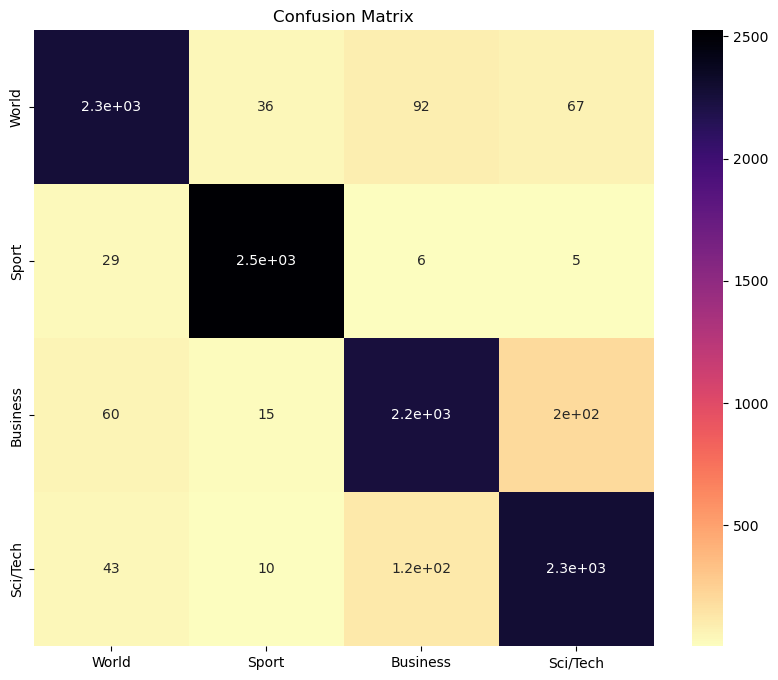

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))

# plot the heat map 
sns.heatmap(
    confusion_matrix(test_df['label'], preds_flat),
    annot=True,
    xticklabels=['World','Sport','Business','Sci/Tech'],
    yticklabels=['World','Sport','Business','Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.show()

In [48]:
# save_model method saves the model along with its metadata in the specified path
trainer.save_model('models')